In [1]:
import numpy as np
import pandas as pd
import glob, os
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 150)

In [3]:
path = r'C:\Users\БФедин\OneDrive - GENERIX\InventoryReports\Baltika'
all_files = glob.glob(path + "/*.txt")

In [4]:
col_specification = [(0,2),(2,15),(15,28),(28,30),
                     (30,34),(34,36),(36,38),(38,42),(42,52),(52,62)]

In [5]:
li = []

for filename in all_files:
    df = pd.read_fwf(filename, header=None,colspecs=col_specification,float_format='%.f')
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df = df.dropna() # Script drops N/A values. They may appear if file has blank lines.

df.columns = ['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Day','Movement_Month','Movement_Year',
                    'Quantity','Base_Unit_Code']

In [6]:
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']] = \
df[['GLN_Code','EAN_Code','Base_Unit_Code','Case_Count']].astype(str).replace('\.0', '', regex=True)

df['Quantity'] = df['Quantity'].astype(int)

In [7]:
df['Movement_Day'] = df['Movement_Day'].astype(str).replace('\.0', '', regex=True)
df['Movement_Day'] = df['Movement_Day'].str.zfill(2)
df['Movement_Month'] = df['Movement_Month'].astype(str).replace('\.0', '', regex=True)
df['Movement_Month'] = df['Movement_Month'].str.zfill(2)
df['Movement_Year'] = df['Movement_Year'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = df["Movement_Day"] + "-" + df["Movement_Month"] + "-" + df["Movement_Year"]
df['Movement_Date'] = df['Movement_Date'].apply(str).replace('\.0', '', regex=True)
df['Movement_Date'] = pd.to_datetime(df.Movement_Date,format = '%d-%m-%Y', dayfirst=True)
df = df.drop(['Movement_Day','Movement_Month','Movement_Year'], axis=1) 

In [8]:
if 5 in df['Movement_Code']:
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3,5],
                                                      ['Stock','Transit','Shipped','OOS'])
else: 
    df['Movement_Code'] = df['Movement_Code'].replace([1,4,3],
                                                      ['Stock','Transit','Shipped'])

In [9]:
df['Site_Item_Type'] = df['Site_Item_Type'].replace([0,1],
                                                    ['Standard','Promo'])

In [10]:
df = df[['Movement_Code','GLN_Code','EAN_Code','Site_Item_Type',
                  'Case_Count','Movement_Date','Quantity','Base_Unit_Code']]

In [11]:
dfPivot = pd.pivot_table(df,aggfunc='sum',values='Quantity',
                         index=['Movement_Date','EAN_Code','Base_Unit_Code'],
                         columns='Movement_Code').reset_index()

In [12]:
dfPivot = dfPivot.fillna(0)

In [13]:
Movement_Codes_Order = ['Movement_Week','Movement_Date','EAN_Code','Base_Unit_Code',
                        'Stock','Transit','Shipped','OOS','Demand']

dfPivot = dfPivot.reindex(Movement_Codes_Order,axis=1)

In [14]:
dfPivot['Movement_Week'] = 'cw'+dfPivot['Movement_Date'].dt.strftime('%V')

In [15]:
if 'OOS' in df['Movement_Code'].unique():
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped'] + dfPivot['OOS']
else:
    dfPivot['OOS'] = dfPivot['OOS'].fillna(0)
    dfPivot['Demand'] = dfPivot['Shipped']

In [16]:
dfPivot = dfPivot.rename_axis("Line_ID",axis=1)

In [17]:
dfPivot.iloc[:, 4:] = dfPivot.iloc[:, 4:].astype(int)

In [18]:
dfPivot = dfPivot.sort_values(by=['Movement_Date'],ascending=False,inplace=False)

In [19]:
dfPivot.reset_index(drop=True,inplace=True)
dfPivot.sort_index(ascending=False,inplace=True)

--- **Data Aggregation and Cleaning were here** ---

Initially this script included lines meant for data aggregation and cleaning. As the process is going to be the same for all upcoming scripts, these lines are deleted. However, they can be found in the first script related to Safety and Cycle Stock calculation.

--- **Stock Simulation script starts here** ---

Product chosen for this script is one of supplier's topsellers. It's is rarely included in promo activities.

In [20]:
dfPivot = dfPivot[dfPivot['Base_Unit_Code']=='1000253382']

Data sample for the chosen product is displayed below.

In [38]:
print(dfPivot.sample(5))

Line_ID Movement_Week Movement_Date       EAN_Code Base_Unit_Code  Stock  Transit  Shipped  OOS  Demand
701              cw53    2020-12-29  4600682009313     1000253382  73062        0     5166    0    5166
5280             cw35    2020-08-28  4600682009313     1000253382  36823        0     6831   18    6849
1309             cw50    2020-12-13  4600682009313     1000253382  61936    44064     9906    0    9906
5949             cw33    2020-08-11  4600682009313     1000253382  49753    13392     5166    0    5166
4356             cw39    2020-09-21  4600682009313     1000253382  18125    26784     9549    0    9549


We choose calendar day as a period. 

In [22]:
dfOneProduct = dfPivot.groupby('Movement_Date',as_index=False)[['Stock','Shipped','OOS','Demand']].sum()

Aggregated quantities can be observed in the following table.

In [23]:
print(dfOneProduct[['Movement_Date','Demand']].tail(10))

Line_ID Movement_Date  Demand
147        2021-01-09    3105
148        2021-01-10    6237
149        2021-01-11    6228
150        2021-01-12    3636
151        2021-01-13    4203
152        2021-01-14   11430
153        2021-01-15    5931
154        2021-01-16    1944
155        2021-01-17   10404
156        2021-01-18   18999


*Z* is a demand threshold. Below we will calculate the probability for an occurence of demand quantity to be below *Z* value within a chosen period. I have set 15.000 as a demand threshold as it almost equals to the inverse CDF of a normal distribution.

In [24]:
z = 15000 # Random value chosen as a threshold. Just a bit above of the mean value.

*MU* is a mean value for product's demand. In our case it's calculated based on data since August 16th.

In [25]:
mu = np.round(dfOneProduct['Demand'].mean(),decimals=2) # mean value

*Sigma* is standard deviation value for product's demand.

In [26]:
sigma = np.round((np.std(dfOneProduct['Demand'],ddof=1)),decimals=2) # standard deviation or std

In [27]:
print('\n','z:',z,'\n','mu:',mu,'\n','sigma:',sigma)


 z: 15000 
 mu: 7244.08 
 sigma: 4147.2


Below we compute the CDF of a normal distribution - Alpha. It's calculated based on inputs above only.

In [28]:
alpha = np.round(norm.cdf(z,mu,sigma),decimals=2)

In [29]:
print('alpha: ',alpha)

alpha:  0.97


Below we declare additional variables that will be used in further calculations.

What will be calculated:
- Safety Stock
- Cycle Stock
- Stock in Transit
- Total Stock
- Cycle Service Level
- Period Service Level

In [36]:
time = 1000

d = np.maximum(np.random.normal(mu,sigma,time).round(0).astype(int),0)

L = 3      # Lead Time
R = 1      # Review Period 

z1 = norm.ppf(alpha)
x_std = np.sqrt(L+R)*sigma
Ss = np.round(x_std*z1).astype(int)  # Safety Stock
Cs = 1/2 * mu * R                    # Cycle Stock
Is = mu * L                          # In Transit Stock
S = Ss + 2*Cs + Is                   # Total Stock

hand = np.zeros(time,dtype=int)
transit = np.zeros((time,L+1),dtype=int)

hand[0] = S - d[0]
transit[0,-1] = d[0]

stockout_period = np.full(time,False,dtype=bool)   # Flags if there is a shortage during a period.
stockout_cycle = []                                # Flags if we had a shortage at any time during the last cycle.

for t in range(1,time):
    if transit[t-1,0]>0:
        stockout_cycle.append(stockout_period[t-1])
    hand[t] = hand[t-1] - d[t] + transit[t-1,0]
    stockout_period[t] = hand[t] < 0
    hand[t] = max(0,hand[t]) # In my case excess demand results in lost sales rather than backorders
    transit[t,:-1] = transit[t-1,1:]        
    if 0==t%R:
        net = hand[t] + transit[t].sum()    
        transit[t,L] = S - net
        
print("Alpha:",alpha*100)
SL_alpha = 1-sum(stockout_cycle)/len(stockout_cycle)
print("Cycle Service Level:",round(SL_alpha*100,2))

SL_period = 1-sum(stockout_period)/time
print("Period Service Level:",round(SL_period*100,2),'\n')

df_sim = pd.DataFrame(data= {"Demand":d,"On-hand":hand,"In-transit":list(transit)})
df_sim = df_sim.iloc[R+L:,:] #Remove initialization periods
print(df_sim)

Alpha: 97.0
Cycle Service Level: 98.22
Period Service Level: 98.3 

     Demand  On-hand                   In-transit
4     11093    15344    [4126, 6678, 7335, 11093]
5     11927     7543   [6678, 7335, 11093, 11927]
6     11190     3031  [7335, 11093, 11927, 11190]
7      8421     1945  [11093, 11927, 11190, 8421]
8      6188     6850   [11927, 11190, 8421, 6188]
..      ...      ...                          ...
995   13896     8180   [11360, 4026, 7114, 13896]
996   10876     8664   [4026, 7114, 13896, 10876]
997    2077    10613   [7114, 13896, 10876, 2077]
998    4324    13403   [13896, 10876, 2077, 4324]
999    5530    21769    [10876, 2077, 4324, 5530]

[996 rows x 3 columns]


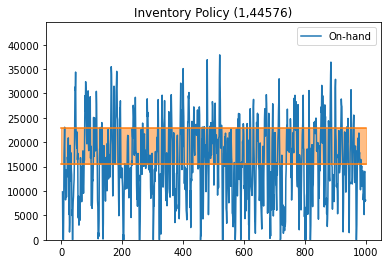

In [35]:
df_sim["On-hand"].plot(title="Inventory Policy (%d,%d)" %(R,S),ylim=(0,S),legend=True,color='C0')

x1, y1 = [0, t], [Ss, Ss] 

x2, y2 = [0, t], [Ss + 2*Cs, Ss + 2*Cs]

plt.plot(x1, y1, color='C1')
plt.plot(x2, y2, color='C1')

plt.fill_between(x1, y1, y2, color='C1', alpha=0.5)

Line chart represents the stock simulation for the chosen product. Besides product's parameters that may vary depending on the chosen product (*mean value, standard deviation, etc.*), static variables are the following:
- **Review Period:** 1 day
- **Lead Time:** 3 days
- **Simulation period:** 1000 days

The highlighted orange area shows the cycle stock range during the simulation period.

In my opinion, potential ~98% service level is a good result!